# **LEZIONE 8**

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters: $\sigma$ and $\mu$.

### Exercise 08.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:
    
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$


## Soluzione:

Per portare a termine la richiesta ho ri-utilizzato lo stesso codice utilizzato nella Lezione 5 per il campionamento degli orbitali atomici, solamente implementando il nuovo metodo 
```cpp
double Metropolis :: ProbabilityDistr(double x){
    double e1= exp(-pow(x-_mu,2)/pow(_sigma,2));
    double e2= exp(-pow(x+_mu,2)/pow(_sigma,2));
    double e3= exp((-x*x-_mu*_mu)/pow(_sigma,2));

    return e1 + e2+ 2*e3;
}

```
che resittuische il valore di $|\Psi_T^{\sigma,\mu}(x)|^2$ valutando la funzione nella posizione fornita in input.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def wave_func(x, mu, sigma):
    norm = 2 * sigma * np.sqrt(np.pi) * (1 + np.exp(-(mu**2) / (sigma**2)))
    return (1/norm) * (np.exp(-(x - mu)**2 / (2*sigma**2)) + np.exp((-(x + mu)**2 / (2*sigma**2))))**2

def Vpot(x):
    return (x**2 - 2.5)*x**2
    # return 0.5*x**2  # potenziale armonico alternativo

hbar = 1
m = 1
a = 10
N = 1000  # numero di iterazioni

# Dimensione del passo
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0]  # ampiezza del passo
V = Vpot(x)

# Metodo delle differenze centrali: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1), -1) - 2*np.diag(np.ones(N), 0) + np.diag(np.ones(N-1), 1)
# np.diag(np.array, k) costruisce una matrice diagonale usando np.array
# Il valore di default è k=0. Usa k>0 per le diagonali sopra quella principale,
# e k<0 per quelle sotto la diagonale principale

# Matrice hamiltoniana
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Calcolo degli autovalori e autovettori
E, psi = np.linalg.eigh(H)

# Trasponi e normalizza
psi = np.transpose(psi)
psi = psi / np.sqrt(dx)

print("Energia dello stato fondamentale: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])


Energia dello stato fondamentale:  -0.46046587969271563
1st excited state energy:  0.09742471331760998
2nd excited state energy:  1.971733134393021


La figura seguente mostra un campionamento con parametri di prova dell'orbitale per verificare il corretto funzionamento del codice.

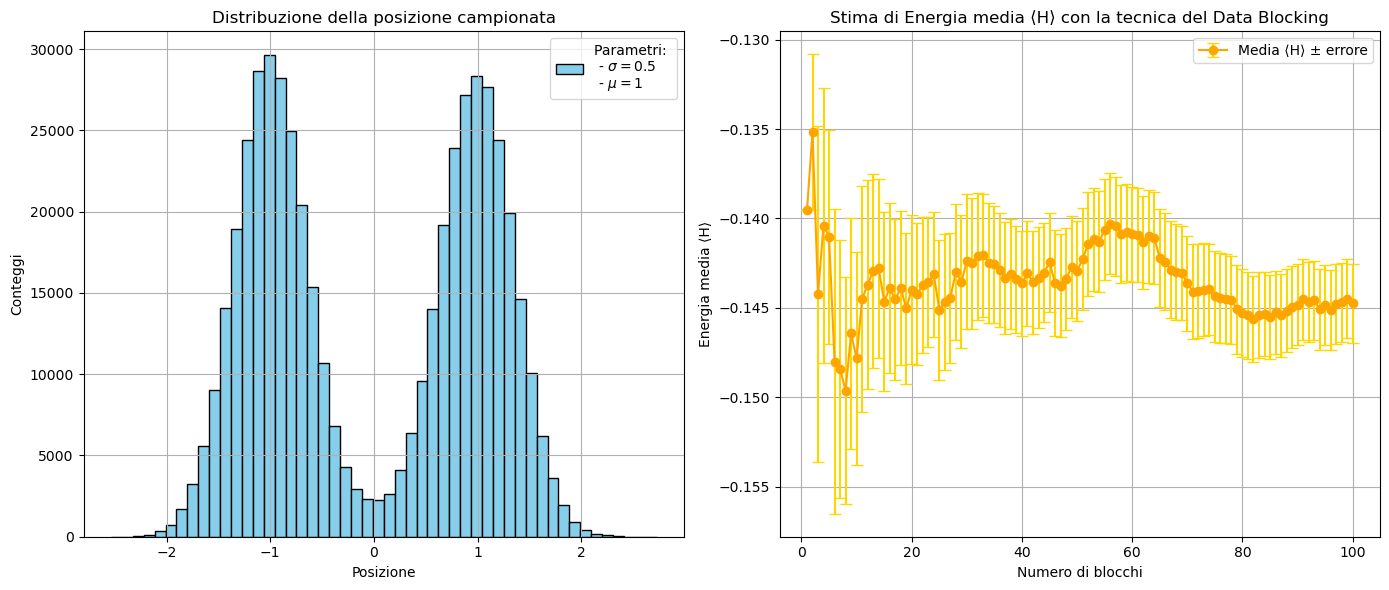

In [3]:
df_h = pd.read_csv("OUTPUT_8.1/data_blocking_final.out", delim_whitespace=True)
df = pd.read_csv("OUTPUT_8.1/campionamento_psi_final.out", delim_whitespace=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Istogramma della posizione
axs[0].hist(df["posizione"], bins=50, edgecolor='black', color='skyblue', label='Parametri: \n - $\sigma =0.5$\n - $\mu = 1$')
axs[0].set_xlabel("Posizione")
axs[0].set_ylabel("Conteggi")
axs[0].set_title("Distribuzione della posizione campionata")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Energia con errore
axs[1].errorbar(df_h["n_block"], df_h["H_average"], yerr=df_h["errore"], fmt='o-', color='orange', ecolor='gold', capsize=4,label='Media ⟨H⟩ ± errore')
axs[1].set_xlabel("Numero di blocchi")
axs[1].set_ylabel("Energia media ⟨H⟩")
axs[1].set_title("Stima di Energia media ⟨H⟩ con la tecnica del Data Blocking")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

**Parametri del grafico:**

- **Blocchi:**  100
- **Passi in ogni blocco:**  5000

### Exercise 08.2

Scrivere un altro main che faccia il simulated annealing

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a Simulated Annealing (SA) algorithm.
Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.

- Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- show a picture of the estimation of $\langle {\hat H} \rangle_T$  and its statistical uncertainty as a function of the number of blocks/MC steps < style="color:red">for the set of parameters which minimize $\langle {\hat H} \rangle_T$ quindi a paramentri fissati
- show also a picture **of the sampled** $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

## Soluzione:

Per ottimizzare i parametri $\mu$ e $\sigma$ al fine di raggiungere lo stato fondamentale del sistema, ho implementato un algoritmo basato sul metodo del Simulated Annealing.
Questa è una tecnica di ottimizzazione che associa il problema da risolvere a un sistema fisico in raffreddamento. Se il raffreddamento avviene in maniera sufficientemente lenta, le particelle avranno tempo di esplorare l’intero spazio delle fasi e raggiungere il minimo globale dell’energia.

L’idea è quindi di far variare i parametri $\mu$ e $\sigma$ assegnando loro una mobilità proporzionale alla temperatura del sistema. A ogni passo si valuta se accettare o rifiutare una modifica dei parametri in base all’energia precedente e a quella attuale, e successivamente si abbassa la temperatura.


#### Algoritmo:

Dopo aver inizializzato i parametri $\mu$, $\sigma$ e la temperatura iniziale $T_0$, l’algoritmo segue i seguenti passaggi:

1) Abbassamento della temperatura (secondo una legge lineare)
```cpp
for(int i=0; i<n_temp;i++)
        B = double(i+1);
        double T = 1./B;
```

2) Proposta di un nuovo stato per i parametri:
Si propone una variazione casuale dei parametri secondo un passo Gaussiano
```cpp
 mu = fabs(mu_old + rnd.Gauss(0.,d_mu*T/T0));
 sigma = fabs(sigma_old + rnd.Gauss(0.,d_sigma*T/T0));
 metro.SetParam( sigma, mu); // setto i nuovi parametri
```

3) Calcolo dell’energia:
Si calcola il valore medio dell’Hamiltoniana usando l’algoritmo Metropolis per campionare la funzione d’onda di prova:
```cpp
metro.Integral_BA( n_blocks, n_steps);
H_ave = metro.get_H_ave();  
err = metro.get_H_err();
```

4) Accettazione o rifiuto della configurazione proposta
Il nuovo stato viene accettato con probabilità:
```cpp
double alpha= fmin(1, (Boltzmann( B, Hnew, Hold)));
double r = rnd.Rannyu() ;
if( r <= alpha ) ->accept
```

In [4]:
df2 = pd.read_csv("OUTPUT_8.2/simulated_annealing.out", delim_whitespace=True)
sampling =pd.read_csv("OUTPUT_8.2/campionamento_psi_final.out", delim_whitespace=True)
print(df2.tail())
mu = df2["mu"]
sigma = df2["sigma"]
step= df2["n_block"]


     n_block         T     sigma        mu       <H>     H_err
995      996  0.001004  0.589267  0.817356 -0.440388  0.001396
996      997  0.001003  0.589267  0.817356 -0.440388  0.001365
997      998  0.001002  0.589267  0.817356 -0.440388  0.001575
998      999  0.001001  0.589267  0.817356 -0.440388  0.001129
999     1000  0.001000  0.590118  0.817450 -0.438089  0.001263


Sono andato a visualizzare il processo di ricerca di mu e sigma nello spazio dei parametri. 
Su $x$ abbiamo i valori del parametro $\mu$, su y quelli del parametro $\sigma$

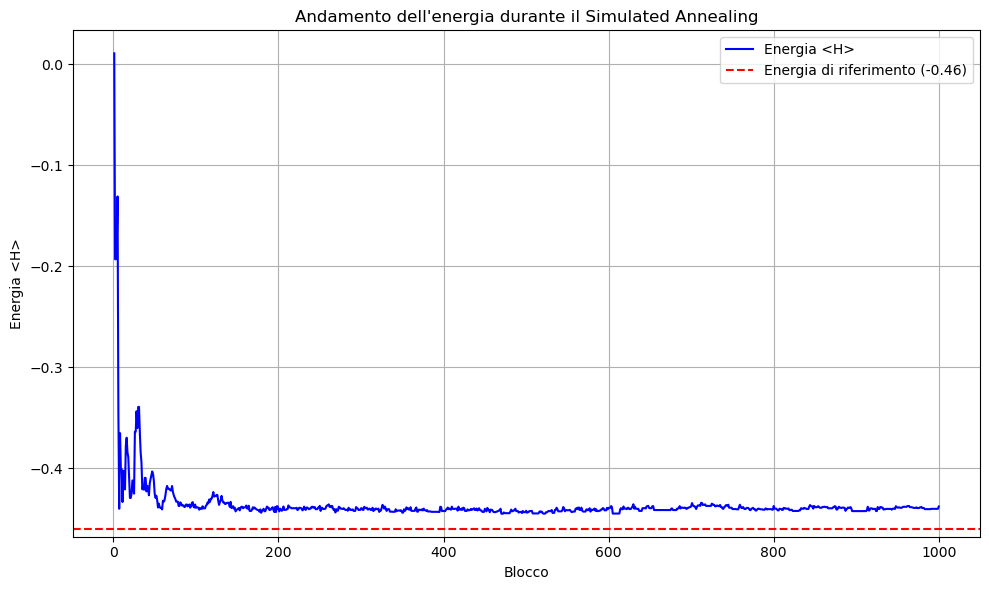

In [5]:
x = df2["n_block"]
y = df2["<H>"]

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Energia <H>', color='blue')
plt.axhline(y=-0.46, color='red', linestyle='--', label='Energia di riferimento (-0.46)')  # Linea rossa

plt.xlabel("Blocco")
plt.ylabel("Energia <H>")
plt.title("Andamento dell'energia durante il Simulated Annealing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notiamo che inizialmente per valori di temperatura elevati, il processo di ricerca dei parametri permette di esplorare vari valori, portando ad un oscillazione nei valori dell'energia media. Con il progressivo abbassamento della temperatura e il raggiungimento di energie minori l'algoritmo inizia ad ottenere valori di energia sempre più stabili nelle vicinanze del valore teorico di ground state $H \sim -0.46$.

Di pari passo si può visualizzare lo stabilizzarsi dei parametri attorno a valori ottimali all'aumentare del numero di step; mostro questo processo nella seguente figura.

Fit parametrs:
	Mu: 0.814
	Sigma: 0.608
	Normalization: 0.397
Fit function:
	$\Psi(x) = \dfrac{1}{2 \cdot 0.608 \cdot \sqrt{\pi} \cdot \Big(1 + e^{-\frac{0.814^2}{0.608^2}}\Big)} \cdot \left( e^{-\frac{(x - 0.814)^2}{2 \cdot 0.608^2}} + e^{-\frac{(x + 0.814)^2}{2 \cdot 0.608^2}} \right)$


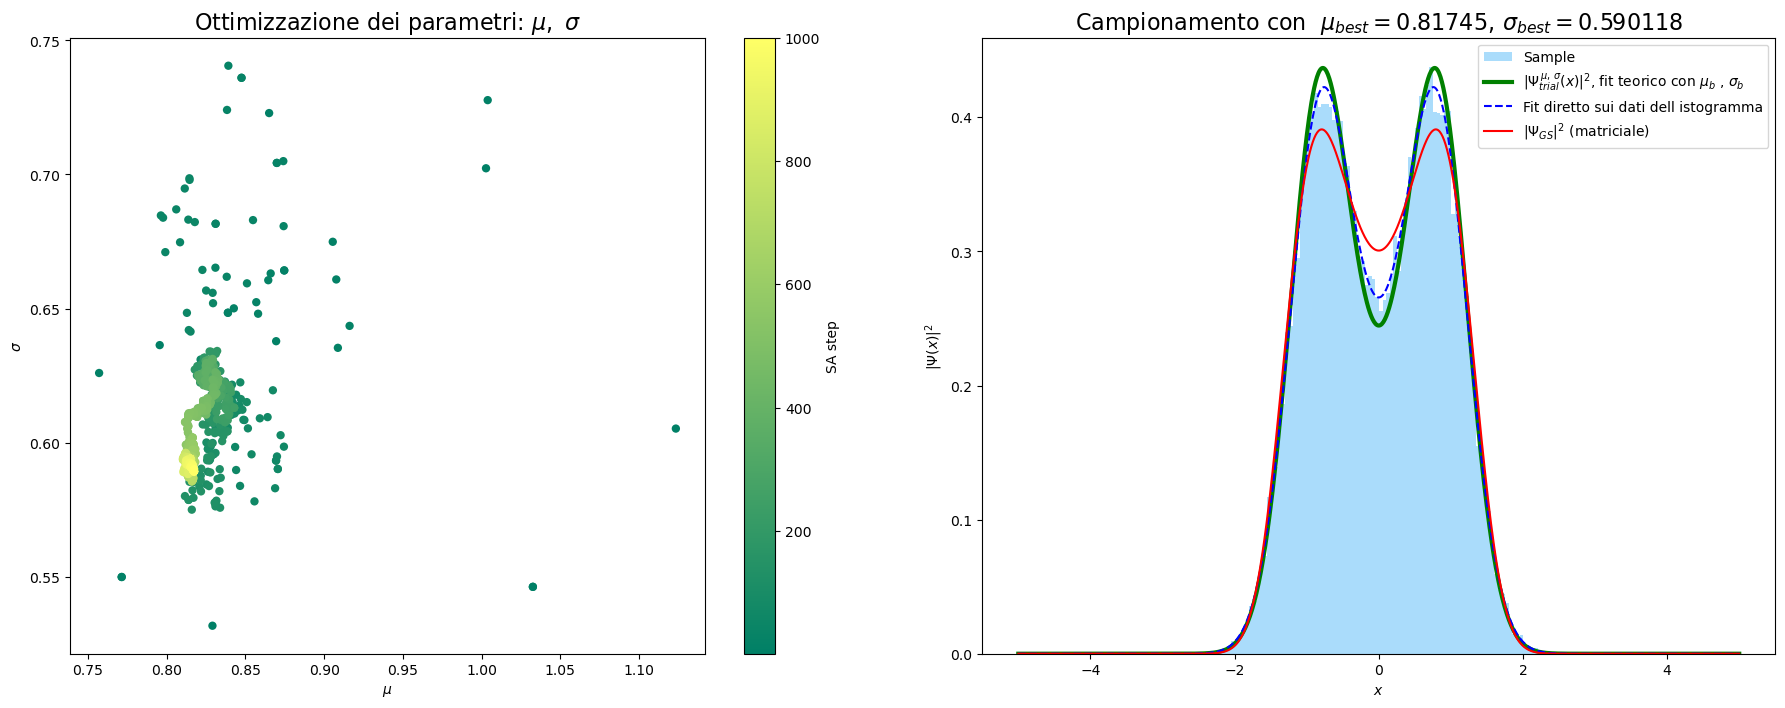

In [6]:
mu_best= 0.817450 
sigma_best = 0.590118  
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)
fig, axs = plt.subplots(1, 2, figsize=(22, 8), gridspec_kw={'wspace': 0.15})

colors = step
scatter = axs[0].scatter(mu, sigma, c=colors, cmap='summer', edgecolors='none')
x_psi = np.linspace(-a/2, a/2, N)

cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('SA step')
axs[0].set_xlabel(r'$\mu$')
axs[0].set_ylabel(r'$\sigma$')
axs[0].set_title(r'Ottimizzazione dei parametri: $\mu, \ \sigma$', fontsize = 16)

hist = axs[1].hist(sampling["posizione"], bins=100, density=True, color='lightskyblue', alpha=0.7, label="Sample")
axs[1].plot(x_psi, wave_func(x_psi, mu_best, sigma_best), c='green', lw=3, label=r'$|\Psi_{trial}^{\, \mu, \, \sigma}(x)|^2$, fit teorico con $\mu_b$ , $\sigma_b$')
popt, pcov = curve_fit(wave_func, hist[1][:-1], hist[0])
axs[1].plot(x_psi, wave_func(x_psi,*popt), c='blue', ls='--', label='Fit diretto sui dati dell istogramma')
axs[1].plot(x_psi, (psi[0])**2, color='red', label=r'$|\Psi_{GS}|^2$ (matriciale)')

mu_fit = popt[0]
mu_str = "{:.3f}".format(mu_fit)
sigma_fit = popt[1]
sigma_str = "{:.3f}".format(sigma_fit)
norm_fit = 2 * sigma_fit * np.sqrt(np.pi) * (1 + np.exp(-(mu_fit**2) / (sigma_fit**2)))
norm_str = "{:.3f}".format(1/norm_fit)
print('Fit parametrs:\n\tMu: ' +mu_str+ '\n\tSigma: ' +sigma_str+ '\n\tNormalization: ' +norm_str)
fit_str = rf"$\Psi(x) = \dfrac{{1}}{{2 \cdot {sigma_str} \cdot \sqrt{{\pi}} \cdot \Big(1 + e^{{-\frac{{{mu_str}^2}}{{{sigma_str}^2}}}}\Big)}} \cdot \left( e^{{-\frac{{(x - {mu_str})^2}}{{2 \cdot {sigma_str}^2}}}} + e^{{-\frac{{(x + {mu_str})^2}}{{2 \cdot {sigma_str}^2}}}} \right)$"

print("Fit function:\n\t" + fit_str)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$|\Psi(x)|^2$')
axs[1].set_title(r'Campionamento con  $\mu_{best}=' +str(mu_best)+ ', \, \sigma_{best}=' +str(sigma_best)+ '$', fontsize = 16)
axs[1].legend()

plt.tight_layout()

plt.show()

- Il plot sulla sinistra mostra l'andamento degli iperparametri nello spazio bidimensionale dei valori di $\mu e \sigma$. I nuovi valori di questi venivano volta per volta proposti tramite step randomici con andamento gaussiano. Di pari passo alla graduale decrescita della temperatura T da $T=1$  a $ T -> 0$ ho deciso di diminuire la varianza dello step Gaussiano riscalandola col valore attuale della temperatura. In questo modo, avvicinandomi al valore ottimale, ho potuto generare proposte sempre più precise e concentrate intorno ai valori migliori, migliorando così la stima dell'energia dello stato fondamentale.

- Il plot sulla destra mostra invece il campionamento finale della funzione d'onda, ottenuto con $\mu_{best}$ e $\sigma_{best}$. Possiamo notare una leggera differenza rispetto al valore matriciale soprattutto in un intorno di $x=0$ per regioni più lontane dall'origine c'è un maggiore accordo.

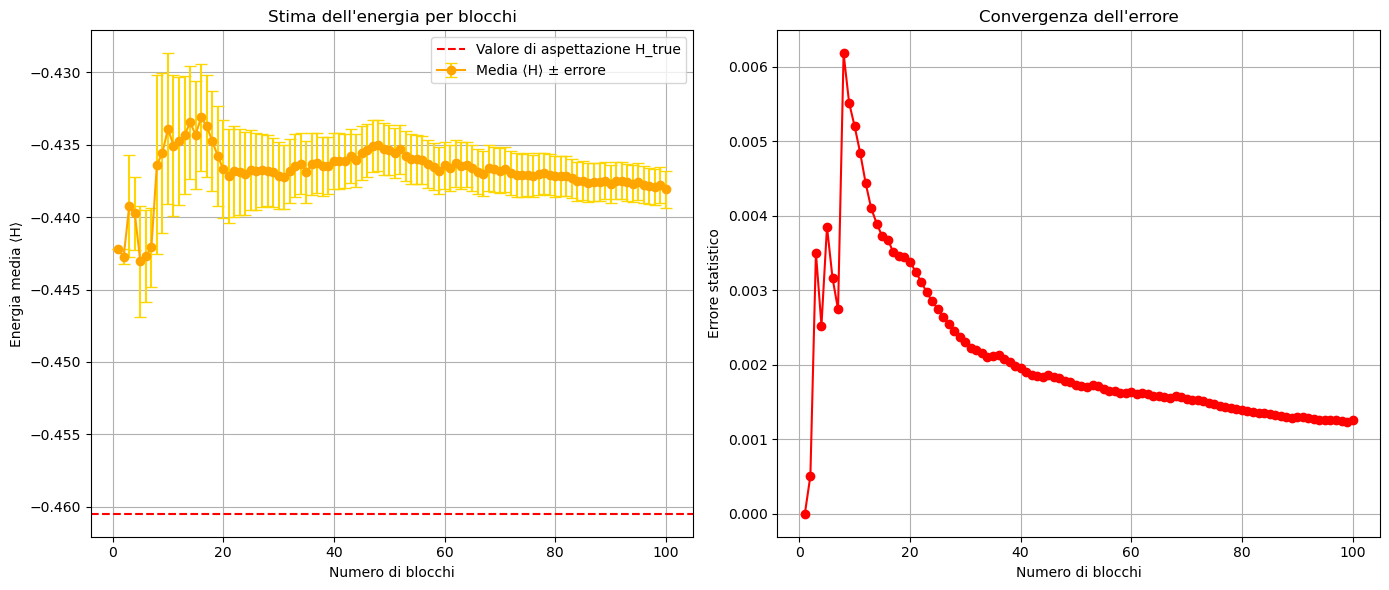

In [7]:
df2_h = pd.read_csv("OUTPUT_8.2/data_blocking.out", delim_whitespace=True)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#
axs[0].errorbar(df2_h["n_block"], df2_h["H_average"], yerr=df2_h["errore"],
                fmt='o-', color='orange', ecolor='gold', capsize=4, label='Media ⟨H⟩ ± errore')
axs[0].axhline(y=E[0], c='red', linestyle='--', label='Valore di aspettazione H_true')

axs[0].set_xlabel("Numero di blocchi")
axs[0].set_ylabel("Energia media ⟨H⟩")
axs[0].set_title("Stima dell'energia per blocchi")
axs[0].grid(True)
axs[0].legend()

# Plot 2: Errore in funzione dei blocchi
axs[1].plot(df2_h["n_block"], df2_h["errore"], color='r', marker='o')
axs[1].set_xlabel("Numero di blocchi")
axs[1].set_ylabel("Errore statistico")
axs[1].set_title("Convergenza dell'errore")
axs[1].grid(True)

plt.tight_layout()
plt.show()

I grafici superiori mostrano l’evoluzione dell’energia del sistema durante il Simulated Annealing, con l’errore riportato a destra. Man mano che i parametri $\mu$ e $\sigma$ si avvicinano a $\mu_{best}$ e $\sigma_{best}$, l’energia diminuisce, anche se non raggiunge il valore atteso calcolato tramite l’equazione matriciale nel materiale supplementare, a causa di limiti nell’algoritmo.

- Numero di passi di Simulated Annealing : 1000

I grafici inferiori mostrano il valore medio dell’energia del sistema calcolato con il metodo del blocking e il suo errore, una volta ottimizzati i parametri, cioè utilizzando $\mu_{best}$ e $\sigma_{best}$. Come osservato nei grafici superiori, l’algoritmo converge a un limite superiore per l’energia dello stato fondamentale, nuovamente calcolata tramite la rappresentazione matriciale.

- Numero di blocchi : 100
- Passi in ogni blocco : 5000